# Исследование одного типа данных из nvprof профиля

In [2]:
%matplotlib inline
import re
import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

In [3]:
time_field_index = 0
duration_field_index = 1
SSMem_field_index = 9
DSMem_field_index = 10
size_field_index = 11
throughput_field_index = 12
src_field_index = 13
dst_field_index = 14
context_index = 16
stream_index = 17
name_field_index = 18

title_pattern = re.compile("^(Start|s).*")
cuda_pattern = re.compile("\[CUDA .*\]")

trace_dir1 = "Tensorflow-HP"
trace_dir2 = "HPCG"
#filename1 = "nvidia-smi-tfhp.csv"
filename1 = "nvprof-trace-tfhp.csv"
#filename2 = "nvidia-smi-hpcg.csv"
filename2 = "nvprof-trace-hpcg.csv"

maxrows = None

file1 = os.path.join(trace_dir1,filename1)
file2 = os.path.join(trace_dir2,filename2)

In [4]:
print "Reading",file1

columns = [time_field_index, duration_field_index,
           SSMem_field_index, DSMem_field_index,
           size_field_index, throughput_field_index,
           src_field_index, dst_field_index,
           context_index, stream_index,
           name_field_index]


Reading Tensorflow-HP/nvprof-trace-tfhp.csv


In [5]:
print file1
df_tf = pd.read_csv(file1, header = 0, usecols = columns, 
                 skiprows=[0,1,2,4], nrows = maxrows)
print df_tf.shape

Tensorflow-HP/nvprof-trace-tfhp.csv
(233029, 11)


# Remove rows with no Throughput

In [7]:
df_tf_thr = df_tf.loc[df_tf["Throughput"].notnull()]
df_tf_thr.shape

(16231, 11)

In [8]:
df_tf_thr.iloc[:3]

,Start,Duration,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
0,0.817201,0.004128,NaN,NaN,0.000980,0.231928,Device,NaN,1,7,[CUDA memset]
1,1.201508,0.002016,NaN,NaN,0.001953,0.946105,Pinned,Device,1,15,[CUDA memcpy HtoD]
2,1.201676,0.001248,NaN,NaN,0.000004,0.002985,Pinned,Device,1,15,[CUDA memcpy HtoD]


In [10]:
df_tf_thr.Name.unique()

array(['[CUDA memset]', '[CUDA memcpy HtoD]', '[CUDA memcpy DtoD]',
       '[CUDA memcpy DtoH]'], dtype=object)

In [12]:
df_tf_thr['FullName']   = df_tf_thr['Name'] + " " + df_tf_thr['SrcMemType']+ df_tf_thr['DstMemType'].fillna("")


/Users/peterbryzgalov/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
df_tf_thr.iloc[:3]

,Start,Duration,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name,FullName
0,0.817201,0.004128,NaN,NaN,0.000980,0.231928,Device,NaN,1,7,[CUDA memset],[CUDA memset] Device
1,1.201508,0.002016,NaN,NaN,0.001953,0.946105,Pinned,Device,1,15,[CUDA memcpy HtoD],[CUDA memcpy HtoD] PinnedDevice
2,1.201676,0.001248,NaN,NaN,0.000004,0.002985,Pinned,Device,1,15,[CUDA memcpy HtoD],[CUDA memcpy HtoD] PinnedDevice


In [14]:
# Convert unique values in column "FullName" to new columns
def mergeColumnNames(df_org):
    df = df_org.pivot(index = 'Start', columns = 'FullName', 
                         values = 'Throughput')
    df = df.fillna(0)  # Fill empty cells with 0-s
    return df
#df_tf_throughput.iloc[:10]

In [15]:
df_tf_throughput = mergeColumnNames(df_tf_thr)

In [17]:
df_tf_throughput.iloc[-5:-1]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice,[CUDA memset] Device
Start,,,,,
53.844560,0.0,0.0,0.0,0.0,0.008169
53.852025,0.0,0.0,0.0,0.0,0.008169
53.859254,0.0,0.0,0.0,0.0,0.008169
53.875775,0.0,0.0,0.0,0.0,0.007761


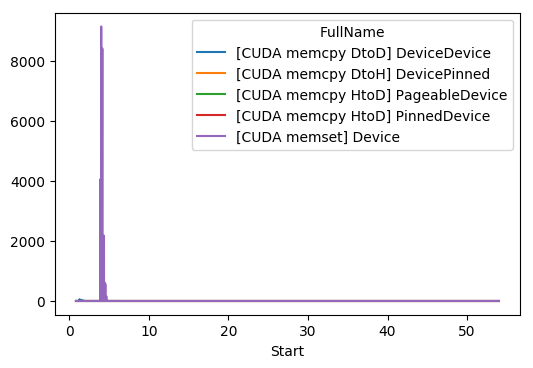

In [18]:
df_tf_throughput.plot()

In [19]:
def appendMaxValues2ColumnNames(df,series):
    cols = len(df.columns)
    col_names = []
    for i in range(0,cols):
        col_names.append(series+df.columns[i]+" " +'{:.3f}'.format(df.iloc[:,i].max()))
    df.columns = col_names
    return df

In [20]:
df_tf_throughput = appendMaxValues2ColumnNames(df_tf_throughput,"TF")

In [21]:
df_tf_throughput.iloc[:5]

,TF[CUDA memcpy DtoD] DeviceDevice 47.609,TF[CUDA memcpy DtoH] DevicePinned 0.006,TF[CUDA memcpy HtoD] PageableDevice 0.052,TF[CUDA memcpy HtoD] PinnedDevice 2.458,TF[CUDA memset] Device 9155.273
Start,,,,,
0.817201,0.0,0.0,0.0,0.000000,0.231928
1.201508,0.0,0.0,0.0,0.946105,0.000000
1.201676,0.0,0.0,0.0,0.002985,0.000000
1.201812,0.0,0.0,0.0,0.002985,0.000000
1.201944,0.0,0.0,0.0,0.186265,0.000000


In [22]:
df_DD_TF = df_tf_throughput.filter(regex=(".*DtoD.*"))

In [24]:
df_DD_TF.iloc[:5]

,TF[CUDA memcpy DtoD] DeviceDevice 47.609
Start,
0.817201,0.0
1.201508,0.0
1.201676,0.0
1.201812,0.0
1.201944,0.0


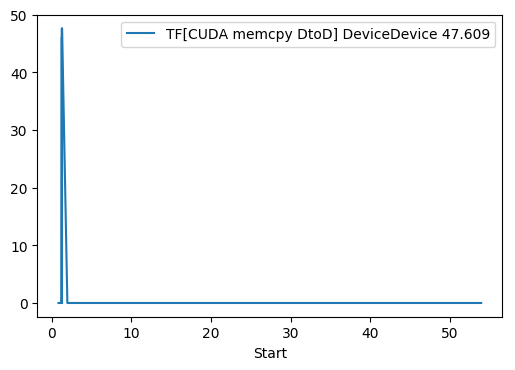

In [25]:
df_DD_TF.plot()

In [36]:
plt.rcParams['figure.figsize'] = 12,6

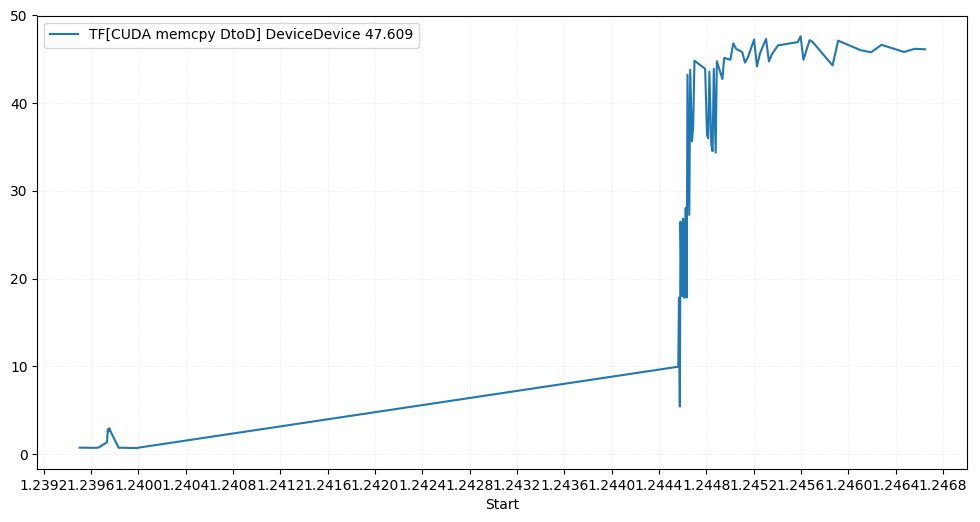

In [61]:
df_DD_TF.iloc[480:550].plot()
ax = plt.gca()
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))

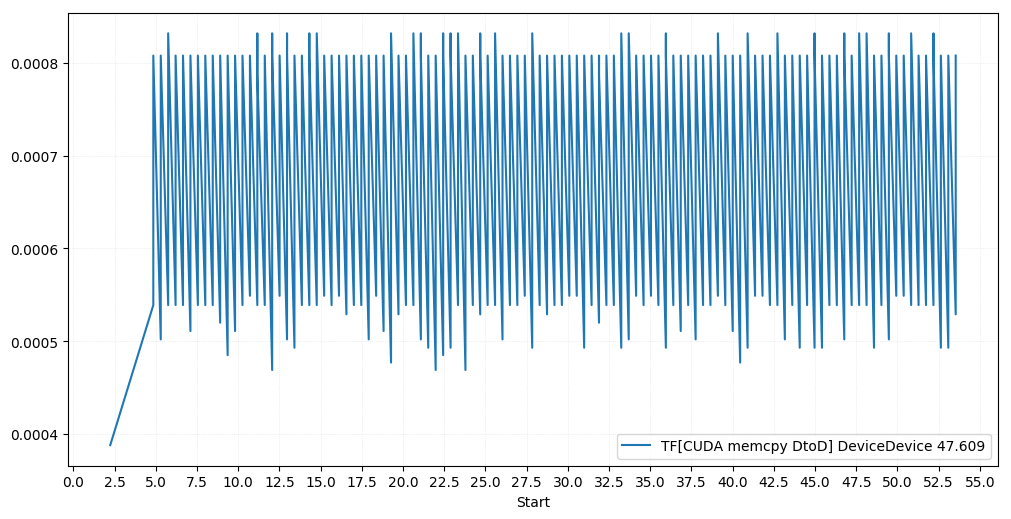

In [42]:
df_DD_TF.iloc[270:].plot()
ax = plt.gca()
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))

## Select columns with memory operations

In [8]:
df_tf_cuda = df_tf.loc[df_tf['Name'].str.contains('\[CUDA')]
df_hpcg_cuda = df_hpcg.loc[df_hpcg['Name'].str.contains('\[CUDA')]

In [17]:
df_tf_cuda[500:530]

NameError: name 'df_tf_cuda' is not defined

In [10]:
df_tf_cuda['Name'][:3]

0         [CUDA memset]
1    [CUDA memcpy HtoD]
2    [CUDA memcpy HtoD]
Name: Name, dtype: object

In [11]:
df_tf_cuda['FullName'] = df_tf_cuda['Name']
df_tf_cuda[:3]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Start,Duration,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name,FullName
0,0.817201,0.004128,NaN,NaN,0.000980,0.231928,Device,NaN,1,7,[CUDA memset],[CUDA memset]
1,1.201508,0.002016,NaN,NaN,0.001953,0.946105,Pinned,Device,1,15,[CUDA memcpy HtoD],[CUDA memcpy HtoD]
2,1.201676,0.001248,NaN,NaN,0.000004,0.002985,Pinned,Device,1,15,[CUDA memcpy HtoD],[CUDA memcpy HtoD]


In [13]:
df_hpcg_cuda.iloc[:5]

,Start,Duration,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name,FullName
0,12.257619,0.002080,NaN,NaN,0.000107,0.050148,Pageable,Device,1,7,[CUDA memcpy HtoD],[CUDA memcpy HtoD] PageableDevice
1,17.538188,0.003712,NaN,NaN,0.000004,0.001004,Device,NaN,1,7,[CUDA memset],[CUDA memset] Device
3,17.557663,0.003168,NaN,NaN,0.000004,0.001176,Device,Pageable,1,7,[CUDA memcpy DtoH],[CUDA memcpy DtoH] DevicePageable
4,17.564471,0.004256,NaN,NaN,0.000103,0.023633,Device,NaN,1,7,[CUDA memset],[CUDA memset] Device
5,17.564478,0.002432,NaN,NaN,0.000103,0.041358,Device,NaN,1,7,[CUDA memset],[CUDA memset] Device


In [17]:
df_tf_throughput.iloc[:5]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice,[CUDA memset] Device
Start,,,,,
0.817201,0.0,0.0,0.0,0.000000,0.231928
1.201508,0.0,0.0,0.0,0.946105,0.000000
1.201676,0.0,0.0,0.0,0.002985,0.000000
1.201812,0.0,0.0,0.0,0.002985,0.000000
1.201944,0.0,0.0,0.0,0.186265,0.000000


In [21]:
df_hpcg_throughput.iloc[:5]

,HPCG[CUDA memcpy DtoD] DeviceDevice 97.813,HPCG[CUDA memcpy DtoH] DevicePageable 8.031,HPCG[CUDA memcpy DtoH] DevicePinned 12.210,HPCG[CUDA memcpy HtoD] PageableDevice 6.859,HPCG[CUDA memcpy HtoD] PinnedDevice 11.319,HPCG[CUDA memset] Device 18084.491
Start,,,,,,
12.257619,0.0,0.000000,0.0,0.050148,0.0,0.000000
17.538188,0.0,0.000000,0.0,0.000000,0.0,0.001004
17.557663,0.0,0.001176,0.0,0.000000,0.0,0.000000
17.564471,0.0,0.000000,0.0,0.000000,0.0,0.023633
17.564478,0.0,0.000000,0.0,0.000000,0.0,0.041358


In [22]:
# Concatenate columns of two DFs into one DF
df_full = pd.concat([df_tf_throughput,df_hpcg_throughput], axis = 1).fillna(0)

In [23]:
df_full.iloc[:5]

,TF[CUDA memcpy DtoD] DeviceDevice 47.609,TF[CUDA memcpy DtoH] DevicePinned 0.006,TF[CUDA memcpy HtoD] PageableDevice 0.052,TF[CUDA memcpy HtoD] PinnedDevice 2.458,TF[CUDA memset] Device 9155.273,HPCG[CUDA memcpy DtoD] DeviceDevice 97.813,HPCG[CUDA memcpy DtoH] DevicePageable 8.031,HPCG[CUDA memcpy DtoH] DevicePinned 12.210,HPCG[CUDA memcpy HtoD] PageableDevice 6.859,HPCG[CUDA memcpy HtoD] PinnedDevice 11.319,HPCG[CUDA memset] Device 18084.491
Start,,,,,,,,,,,
0.817201,0.0,0.0,0.0,0.000000,0.231928,0.0,0.0,0.0,0.0,0.0,0.0
1.201508,0.0,0.0,0.0,0.946105,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1.201676,0.0,0.0,0.0,0.002985,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1.201812,0.0,0.0,0.0,0.002985,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1.201944,0.0,0.0,0.0,0.186265,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
plt.rcParams['figure.figsize'] = 8,4

/usr/local/lib/python2.7/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


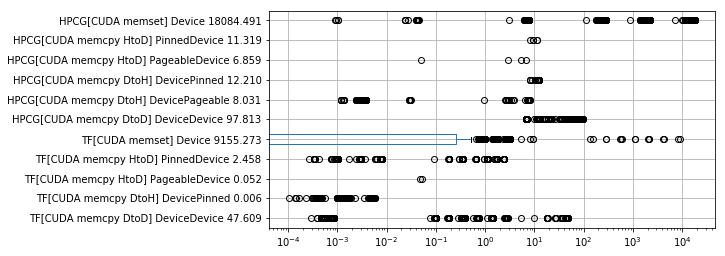

In [25]:
df_full.plot.box(logx = True, grid = True, vert=False)

### Without memset

In [39]:
df_memcpy = df_full.filter(regex=("^((?!memset).)*$"))
df_memcpy.iloc[:3]

,TF[CUDA memcpy DtoD] DeviceDevice 47.609,TF[CUDA memcpy DtoH] DevicePinned 0.006,TF[CUDA memcpy HtoD] PageableDevice 0.052,TF[CUDA memcpy HtoD] PinnedDevice 2.458,HPCG[CUDA memcpy DtoD] DeviceDevice 97.813,HPCG[CUDA memcpy DtoH] DevicePageable 8.031,HPCG[CUDA memcpy DtoH] DevicePinned 12.210,HPCG[CUDA memcpy HtoD] PageableDevice 6.859,HPCG[CUDA memcpy HtoD] PinnedDevice 11.319
Start,,,,,,,,,
0.817201,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1.201508,0.0,0.0,0.0,0.946105,0.0,0.0,0.0,0.0,0.0
1.201676,0.0,0.0,0.0,0.002985,0.0,0.0,0.0,0.0,0.0


In [59]:
x_arr = []
names = []
for column in df_memcpy: 
    x = df_memcpy[column]
    x = x[x != 0]
    print '{:45.43} {:8.8} st.: {:<7.3f}'.format(column, x.shape, x.iloc[0]),
    arr = x.values
    print 'elm.: {:<6d}'.format(len(arr)),
    x_arr.append(arr)
    names.append(column)
    print '{:3d}'.format(len(x_arr))

TF[CUDA memcpy DtoD] DeviceDevice 47.609      (598,)   st.: 0.077   elm.: 598      1
TF[CUDA memcpy DtoH] DevicePinned 0.006       (660,)   st.: 0.000   elm.: 660      2
TF[CUDA memcpy HtoD] PageableDevice 0.052     (2,)     st.: 0.047   elm.: 2        3
TF[CUDA memcpy HtoD] PinnedDevice 2.458       (519,)   st.: 0.946   elm.: 519      4
HPCG[CUDA memcpy DtoD] DeviceDevice 97.813    (6006,)  st.: 50.752  elm.: 6006     5
HPCG[CUDA memcpy DtoH] DevicePageable 8.031   (5888,)  st.: 0.001   elm.: 5888     6
HPCG[CUDA memcpy DtoH] DevicePinned 12.210    (59,)    st.: 8.219   elm.: 59       7
HPCG[CUDA memcpy HtoD] PageableDevice 6.859   (4,)     st.: 0.050   elm.: 4        8
HPCG[CUDA memcpy HtoD] PinnedDevice 11.319    (5,)     st.: 8.245   elm.: 5        9


In [28]:
plt.rcParams['figure.figsize'] = 12,8

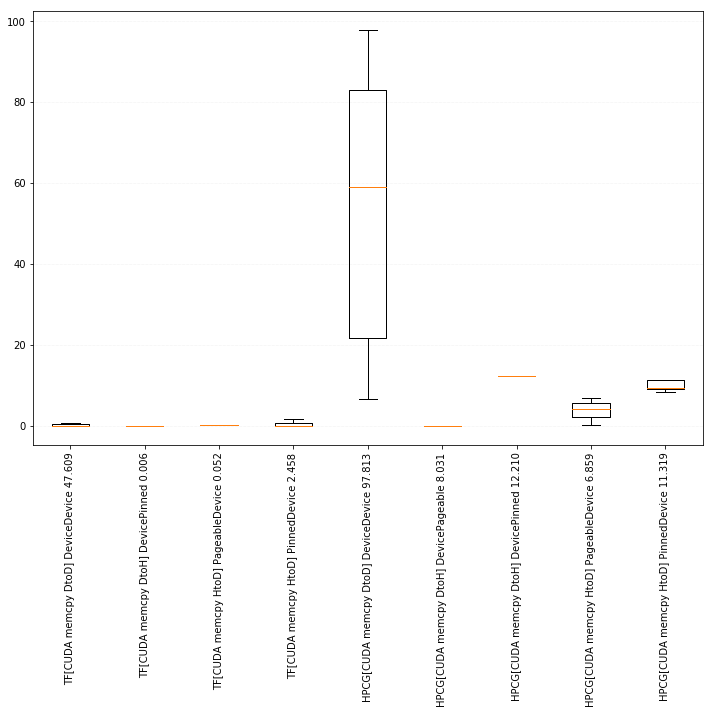

In [29]:
plt.figure()
plt.boxplot(x_arr, 0, '', labels = names)
plt.xticks(rotation=90)
ax = plt.gca()
#ax.set_yscale("log")
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
#plt.savefig("memcpy_box_.pdf", bbox_inches='tight')
plt.show()

### Split df_throughput into several dataframes for plotting

In [30]:
df_DD_TF = df_tf_throughput.filter(regex=(".*DtoD.*"))
df_DD_TF.iloc[:3]

,TF[CUDA memcpy DtoD] DeviceDevice 47.609
Start,
0.817201,0.0
1.201508,0.0
1.201676,0.0


In [31]:
df_DD_HPCG = df_hpcg_throughput.filter(regex=(".*DtoD.*"))
df_DD_HPCG.iloc[:3]

,HPCG[CUDA memcpy DtoD] DeviceDevice 97.813
Start,
12.257619,0.0
17.538188,0.0
17.557663,0.0


## TF vs HPCG DtoD memcpy

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


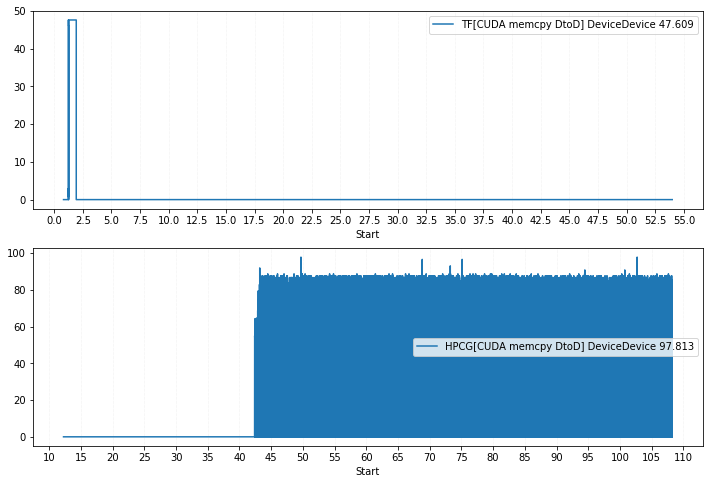

In [32]:
fig, axarr = plt.subplots(2)
df_DD_TF.plot(drawstyle="steps-post",ax = axarr[0])
df_DD_HPCG.plot(drawstyle="steps-post",ax = axarr[1])
for axis in axarr:
    axis.legend()
    axis.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    axis.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()

In [34]:
df_DH = df_full.filter(regex=(".*(HtoD|DtoH).*"))
df_DH.iloc[:3]

,TF[CUDA memcpy DtoH] DevicePinned 0.006,TF[CUDA memcpy HtoD] PageableDevice 0.052,TF[CUDA memcpy HtoD] PinnedDevice 2.458,HPCG[CUDA memcpy DtoH] DevicePageable 8.031,HPCG[CUDA memcpy DtoH] DevicePinned 12.210,HPCG[CUDA memcpy HtoD] PageableDevice 6.859,HPCG[CUDA memcpy HtoD] PinnedDevice 11.319
Start,,,,,,,
0.817201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1.201508,0.0,0.0,0.946105,0.0,0.0,0.0,0.0
1.201676,0.0,0.0,0.002985,0.0,0.0,0.0,0.0


In [38]:
df_DH_TF = df_DH.filter(regex=("^TF.*"))
df_DH_HPCG = df_DH.filter(regex=("^HPCG.*"))
df_DH_TF.iloc[:3]

,TF[CUDA memcpy DtoH] DevicePinned 0.006,TF[CUDA memcpy HtoD] PageableDevice 0.052,TF[CUDA memcpy HtoD] PinnedDevice 2.458
Start,,,
0.817201,0.0,0.0,0.000000
1.201508,0.0,0.0,0.946105
1.201676,0.0,0.0,0.002985


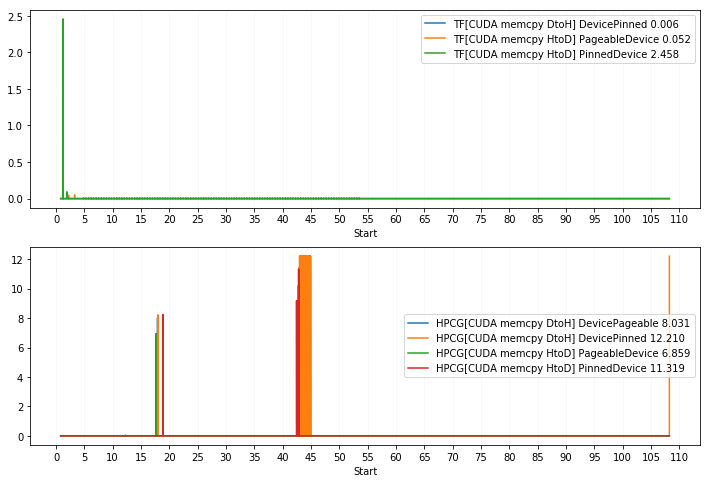

In [37]:
fig, axarr = plt.subplots(2)
df_DH_TF.plot(drawstyle="steps-post",ax = axarr[0])
df_DH_HPCG.plot(drawstyle="steps-post",ax = axarr[1])
for axis in axarr:
    axis.legend()
    axis.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    axis.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()

In [64]:
df_D2H_TF = df_DH_TF.filter(regex=(".*DtoH.*")).fillna(0)
df_D2H_TF.iloc[:3]

,TF[CUDA memcpy DtoH] DevicePinned 0.006
Start,
0.817201,0.0
1.201508,0.0
1.201676,0.0


In [70]:
#df_D2H_TF_nonzero = df_D2H_TF[df_D2H_TF["TF[CUDA memcpy DtoH] DevicePinned 0.006"] != 0]
df_D2H_TF_nonzero = df_D2H_TF[df_D2H_TF.iloc[:,0] != 0]
df_D2H_TF_nonzero.iloc[:5]

,TF[CUDA memcpy DtoH] DevicePinned 0.006
Start,
2.231611,0.000226
2.231713,0.000331
2.231954,0.004208
2.231994,0.001052
2.232025,0.000346


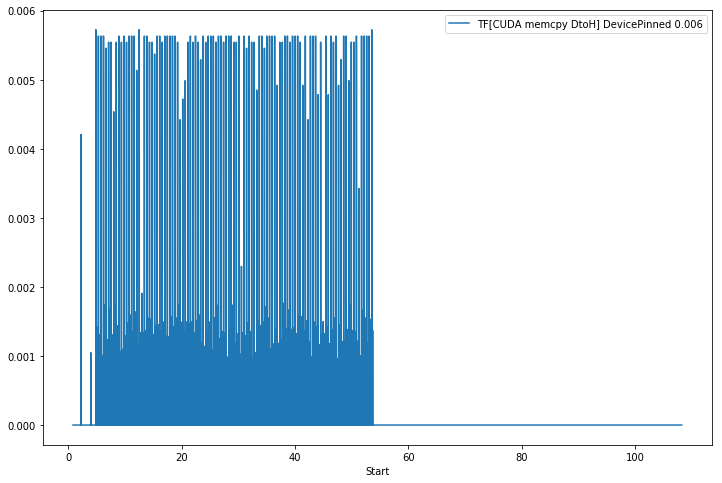

In [71]:
df_D2H_TF.plot()

# Kernels

## Remove memcpy operations from profiles

In [78]:
df_tf_kernel = df_tf.loc[~df_tf['Name'].str.contains('\[CUDA')]
df_hpcg_kernel = df_hpcg.loc[~df_hpcg['Name'].str.contains('\[CUDA')]
df_hpcg_kernel = df_hpcg_kernel.set_index('Start')
df_hpcg_kernel.iloc[:10]

,Duration,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
Start,,,,,,,,,,
17.538247,19.413973,0.00000,512.0,NaN,NaN,NaN,NaN,1,14,"generate_problem_kernel(int, int, int, int, __..."
17.564537,21.684696,0.84375,0.0,NaN,NaN,NaN,NaN,1,7,"setup_halo_kernel(int, int, int, int, int, int..."
17.588889,11.886478,0.00000,0.0,NaN,NaN,NaN,NaN,1,15,"genL2G_kernel(__int64*, int const *, __int64 c..."
17.600780,6.662055,0.00000,0.0,NaN,NaN,NaN,NaN,1,7,"genMat_kernel(double*, int const *, int) [331]"
17.607450,0.083968,0.00000,0.0,NaN,NaN,NaN,NaN,1,7,"set_perm_k(int*, int) [338]"
17.607538,0.083328,0.00000,0.0,NaN,NaN,NaN,NaN,1,7,"set_perm_k(int*, int) [343]"
17.607722,2.724260,0.00000,0.0,NaN,NaN,NaN,NaN,1,7,"CopyMatrixDiagonalToVector_kernel(double*, int..."
17.610462,2.463586,0.00000,512.0,NaN,NaN,NaN,NaN,1,14,"generate_problem_kernel(int, int, int, int, __..."
17.616885,2.719843,0.84375,0.0,NaN,NaN,NaN,NaN,1,7,"setup_halo_kernel(int, int, int, int, int, int..."
